# Signed Directed Bitcoin OTC web of trust network

### Dataset information:
This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

<img src="data/image.png" alt="Drawing" style="width: 350px;"/>

Each line has one rating, sorted by time with the following format: 
    `SOURCE, TARGET, RATING, TIME`

### Read data and build network using NetworkX

In [1]:
# imports
import collections

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

from data_tools import plot_functions as func

%matplotlib notebook

In [2]:
# read file
register_matplotlib_converters()
data = pd.read_csv('data/soc-sign-bitcoinotc.csv', sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
# time is in epochtime format, can be transformed to date time
data

,Source,Target,Rating,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
5,13,10,8,1.289254e+09
6,7,5,1,1.289363e+09
7,2,21,5,1.289371e+09
8,2,20,5,1.289371e+09
9,21,2,5,1.289381e+09


In [3]:
# create the graph
g_bitcoin_otc = nx.from_pandas_edgelist(data, source='Source', target='Target', edge_attr='Rating', create_using=nx.DiGraph)
n_nodes = g_bitcoin_otc.number_of_nodes()

### Network properties

In [4]:
print("Number of nodes:", g_bitcoin_otc.number_of_nodes())
print("Number of edges:", g_bitcoin_otc.number_of_edges())

Number of nodes: 5881
Number of edges: 35592


In [11]:
counts = data.groupby(['Rating']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts

,Rating,Frequency,Probability
0,-10,2413,0.067796
1,-9,20,0.000562
2,-8,31,0.000871
3,-7,14,0.000393
4,-6,5,0.000140
5,-5,179,0.005029
6,-4,27,0.000759
7,-3,91,0.002557
8,-2,182,0.005114
9,-1,601,0.016886


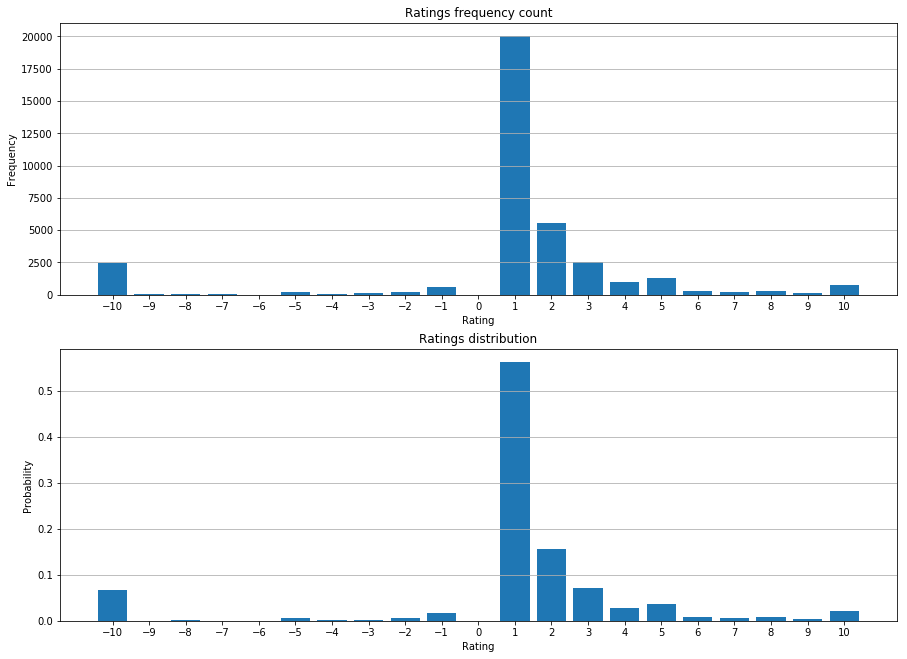

In [13]:
fig = plt.figure()
fig.set_size_inches(15.0, 11.0)

bins = np.linspace(-10,10,21)

# Ratings frequency (count for each rating).
ax = plt.subplot(2, 1, 1)

plt.bar(counts['Rating'], counts['Frequency'])

plt.title('Ratings frequency count')
plt.xlabel('Rating')
plt.ylabel('Frequency')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

# Ratings probability (distribution).
ax = plt.subplot(2, 1, 2)

plt.bar(counts['Rating'], counts['Probability'])

plt.title('Ratings distribution')
plt.xlabel('Rating')
plt.ylabel('Probability')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

plt.show()

In [7]:
# convert dictionary into list of tuples
in_degree_list = [(k, v) for k, v in nx.in_degree_centrality(g_bitcoin_otc).items()] 
out_degree_list = [(k, v) for k, v in nx.out_degree_centrality(g_bitcoin_otc).items()] 
# sort list of tuples using as key degree
in_degree_list = sorted(in_degree_list, key=lambda tup: tup[1], reverse=True)
out_degree_list = sorted(out_degree_list, key=lambda tup: tup[1], reverse=True)
print("20 NODE WITH HIGHEST IN DEGREE \t\t\t20 NODE WITH HIGHEST OUT DEGREE\n")
for i in range(20):
    print("IN Node:\033[1m", in_degree_list[i][0], "\033[0m\tdegree:\033[1m", in_degree_list[i][1], "\033[0m\tOUT Node:\033[1m" , out_degree_list[i][0], "\033[0m\tdegree:\033[1m", out_degree_list[i][1], "\033[0m")

20 NODE WITH HIGHEST IN DEGREE 			20 NODE WITH HIGHEST OUT DEGREE

IN Node: 35 	degree: 0.09098639455782312 	OUT Node: 35 	degree: 0.12976190476190474 
IN Node: 2642 	degree: 0.07006802721088434 	OUT Node: 2642 	degree: 0.06904761904761904 
IN Node: 1810 	degree: 0.05289115646258503 	OUT Node: 1810 	degree: 0.06870748299319727 
IN Node: 2028 	degree: 0.047448979591836735 	OUT Node: 2125 	degree: 0.06751700680272109 
IN Node: 905 	degree: 0.044897959183673466 	OUT Node: 2028 	degree: 0.049829931972789114 
IN Node: 1 	degree: 0.03843537414965986 	OUT Node: 905 	degree: 0.044897959183673466 
IN Node: 4172 	degree: 0.03775510204081632 	OUT Node: 4172 	degree: 0.044897959183673466 
IN Node: 7 	degree: 0.03673469387755102 	OUT Node: 7 	degree: 0.03945578231292517 
IN Node: 4197 	degree: 0.03452380952380952 	OUT Node: 1 	degree: 0.036564625850340135 
IN Node: 13 	degree: 0.03248299319727891 	OUT Node: 3129 	degree: 0.03605442176870748 
IN Node: 2125 	degree: 0.030612244897959183 	OUT Node: 13

In [6]:
# count weighted degree distribution 
weighted_in_degree = dict()
weighted_out_degree = dict()
for instance in data.values:
    weighted_in_degree[instance[0]] = weighted_in_degree.get(instance[0], 0) + instance[2]
    weighted_in_degree[instance[1]] = weighted_in_degree.get(instance[1], 0)
    weighted_out_degree[instance[1]] = weighted_out_degree.get(instance[1], 0) + instance[2]
    weighted_out_degree[instance[0]] = weighted_out_degree.get(instance[0], 0)
in_degree_list_weight = list()

for key, value in weighted_in_degree.items():
    in_degree_list_weight.append((int(key),value/n_nodes))
    
out_degree_list_weight = list()
for key, value in weighted_out_degree.items():
    out_degree_list_weight.append((int(key),value/n_nodes))
    
in_degree_list_weight = sorted(in_degree_list_weight, key=lambda tup: tup[1], reverse=True)
out_degree_list_weight = sorted(out_degree_list_weight, key=lambda tup: tup[1], reverse=True)

print("20 NODE WITH HIGHEST IN DEGREE WEIGHTED \t\t\t20 NODE WITH HIGHEST OUT DEGREE WEIGHTED\n")
for i in range(20):
    print("IN Node:\033[1m", in_degree_list_weight[i][0], "\033[0m\tdegree:\033[1m", out_degree_list_weight[i][1], "\033[0m\tOUT Node:\033[1m" , out_degree_list[i][0], "\033[0m\tdegree:\033[1m", out_degree_list[i][1], "\033[0m")


20 NODE WITH HIGHEST IN DEGREE WEIGHTED 			20 NODE WITH HIGHEST OUT DEGREE WEIGHTED

IN Node: 35 	degree: 0.17701071246386668 	OUT Node: 35 	degree: 0.12976190476190474 
IN Node: 2642 	degree: 0.17275973473898998 	OUT Node: 2642 	degree: 0.06904761904761904 
IN Node: 7 	degree: 0.13620132630505016 	OUT Node: 1810 	degree: 0.06870748299319727 
IN Node: 1 	degree: 0.10440401292297229 	OUT Node: 2125 	degree: 0.06751700680272109 
IN Node: 257 	degree: 0.0802584594456725 	OUT Node: 2028 	degree: 0.049829931972789114 
IN Node: 2028 	degree: 0.08008842033667743 	OUT Node: 905 	degree: 0.044897959183673466 
IN Node: 4291 	degree: 0.07464716884883524 	OUT Node: 4172 	degree: 0.044897959183673466 
IN Node: 1018 	degree: 0.07073626934194865 	OUT Node: 7 	degree: 0.03945578231292517 
IN Node: 13 	degree: 0.06121407923822479 	OUT Node: 1 	degree: 0.036564625850340135 
IN Node: 1396 	degree: 0.05798333616731848 	OUT Node: 3129 	degree: 0.03605442176870748 
IN Node: 4197 	degree: 0.05492263220540724

In [6]:
# display chosen nodes and those connections
def display_network(network, list_of_nodes):
    # get list of edges connected with given nodes
    list_of_edges = network.edges(list_of_nodes)
    # add involved nodes to list_of_nodes to get its position
    for edge in list_of_edges:
        if edge[0] not in list_of_nodes:
            list_of_nodes.append(edge[0])
        if edge[1] not in list_of_nodes:
            list_of_nodes.append(edge[1])
            
    #print("nodes number:", list_of_nodes[0], type(list_of_nodes[0]))
    #print("edges number:", len(list_of_edges))
    pos = nx.layout.spectral_layout(list_of_nodes)
    node_sizes = [1 + 0.5 * i for i in range(len(list_of_nodes))]
    
    M = len(list_of_edges)
    edge_colors = range(2, M + 2)
    print(len(edge_colors))
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    
    plt.figure(1, figsize=(350,350))
    nodes = nx.draw_networkx_nodes(network, pos, nodelist=list_of_nodes, node_size=node_sizes, node_color='blue')
    edges = nx.draw_networkx_edges(network, pos, arrowstyle='->', edgelist=list_of_edges,
                                   arrowsize=5, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.Blues, width=0.6)
#     set alpha value for each edge
    for i in range(M):
         edges[i].set_alpha(edge_alphas[i])

    pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    pc.set_array(edge_colors)
    #plt.rcParams['figure.figsize'] = [350, 350]
    plt.colorbar(pc)
    plt.show()




In [7]:
list_of_best_nodes = [node[0] for node in in_degree_list[:10]]
print(list_of_best_nodes)
# uncomment line below to print network partailly (listed nodes and nodes connected to them)
#display_network(g_bitcoin_otc, list_of_best_nodes)

[35, 2642, 1810, 2028, 905, 1, 4172, 7, 4197, 13]


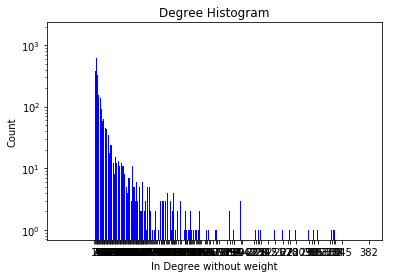

In [7]:
degree_sequence = sorted([d for n, d in g_bitcoin_otc.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree without weight")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

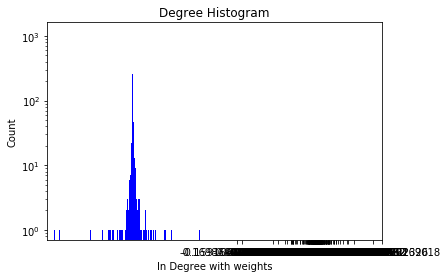

In [17]:
#in_degree_list_weight
degree_sequence_in_weighted = [node[1] for node in in_degree_list_weight]

degreeCount = collections.Counter(degree_sequence_in_weighted)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.0010, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree with weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()


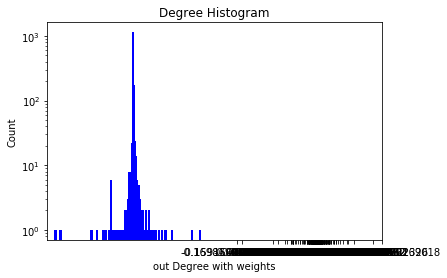

In [20]:
#out_degree_list_weight
degree_sequence_out_weighted = [int(node[1]*100000) for node in out_degree_list_weight]

degreeCount = collections.Counter(degree_sequence_in_weighted)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("out Degree with weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

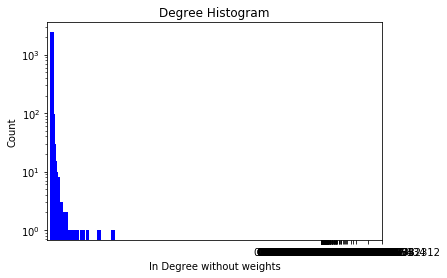

In [23]:
#in_degree_list_not_weight
degree_sequence_in = [node[1] for node in in_degree_list]

degreeCount = collections.Counter(degree_sequence_in)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree without weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=5000)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()


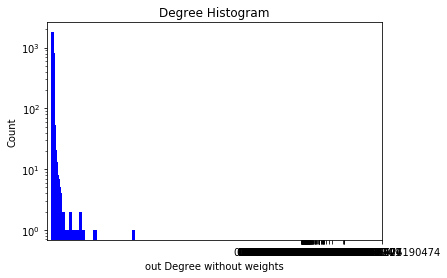

In [25]:
#out_degree_list_not_weight
degree_sequence_out = [node[1] for node in out_degree_list]

degreeCount = collections.Counter(degree_sequence_out)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("out Degree without weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=5000)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

In [26]:
in_not_weight = sorted(in_degree_list, key=lambda tup: tup[0], reverse=True)
out_not_weight = sorted(out_degree_list, key=lambda tup: tup[0], reverse=True)
in_weight = sorted(in_degree_list_weight, key=lambda tup: tup[0], reverse=True)
out_weight = sorted(out_degree_list_weight, key=lambda tup: tup[0], reverse=True)

In [27]:
to_data_frame = list()
for i in range(len(in_not_weight)):
    to_data_frame.append((in_not_weight[i][0], in_not_weight[i][1], out_not_weight[i][1], in_weight[i][1], out_weight[i][1]))
print(to_data_frame[:10])


[(6005, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6004, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6003, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6002, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6000, 0.0, 0.00017006802721088434, 0.00017003910899506886, 0.0), (5999, 0.00017006802721088434, 0.00017006802721088434, 0.0013603128719605509, 0.00017003910899506886), (5998, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (5997, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (5996, 0.00017006802721088434, 0.00017006802721088434, 0.0005101173269852066, 0.0005101173269852066), (5995, 0.00017006802721088434, 0.00017006802721088434, 0.00017003910899506886, 0.00017003910899506886)]


In [28]:
dataframe = pd.DataFrame(to_data_frame)
dataframe

,0,1,2,3,4
0,6005,0.000170,0.000000,0.000000,0.000170
1,6004,0.000170,0.000000,0.000000,0.000170
2,6003,0.000170,0.000000,0.000000,0.000170
3,6002,0.000170,0.000000,0.000000,0.000170
4,6000,0.000000,0.000170,0.000170,0.000000
...,...,...,...,...,...
5876,5,0.000510,0.000510,0.001190,0.001190
5877,4,0.009184,0.010714,0.029757,0.028567
5878,3,0.003571,0.000000,0.000000,-0.001020
5879,2,0.006973,0.007653,0.024316,0.020915
